In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import torch
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [3]:
roi_group_names = ['V1', 'V2', 'V3', 'V4']
roi_group = [[1,2],[3,4],[5,6], [7]]

from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

# File locations

In [4]:
joined_dir  = root_dir+'output/multisubject/gnet8j_mpf_evc_Feb-04-2022_1818/'
roiwise_dir = root_dir+'output/multisubject/gnet8r_mpf_evc_Feb-04-2022_1844/'

output_dir = joined_dir

---
# Reload this GNet8j validation accuracy

In [5]:
checkpoint = torch.load(joined_dir + "model_params")
joined_val_ccs = checkpoint['val_cc']
voxel_roi  = checkpoint['voxel_roi']
subjects = list(voxel_roi.keys())

# Load ROI-wise validation accuracy

In [6]:
roi_timestamp_dir = {
    'V1': '%smodel_params_V1' % roiwise_dir,
    'V2': '%smodel_params_V2' % roiwise_dir,
    'V3': '%smodel_params_V3' % roiwise_dir,
    'hV4': '%smodel_params_hV4' % roiwise_dir
    }

In [7]:
checkpoint = {}
for r,t in roi_timestamp_dir.items():
    checkpoint[r] = torch.load(t)

In [8]:
roiwise_val_ccs = {s: np.zeros_like(v) for s,v in voxel_roi.items()}

for k,(roi_name, cp) in enumerate(checkpoint.items()):
    for subj in voxel_roi.keys():

        roi_mask = cp['group_mask'][subj]
        roiwise_val_ccs[subj][roi_mask] = cp['val_cc'][subj]

# Comparison

In [9]:
from matplotlib import cm
from matplotlib.patches import Patch

subjects = [1,2,3,4,5,6,7,8]
roi_cmap = [cm.get_cmap('rainbow', 5)(0), cm.get_cmap('rainbow', 5)(1), cm.get_cmap('rainbow', 5)(3), cm.get_cmap('rainbow', 5)(4)]
subj_cmap = [cm.get_cmap('rainbow', len(subjects)+1)(k) for k in range(len(subjects)+1)]

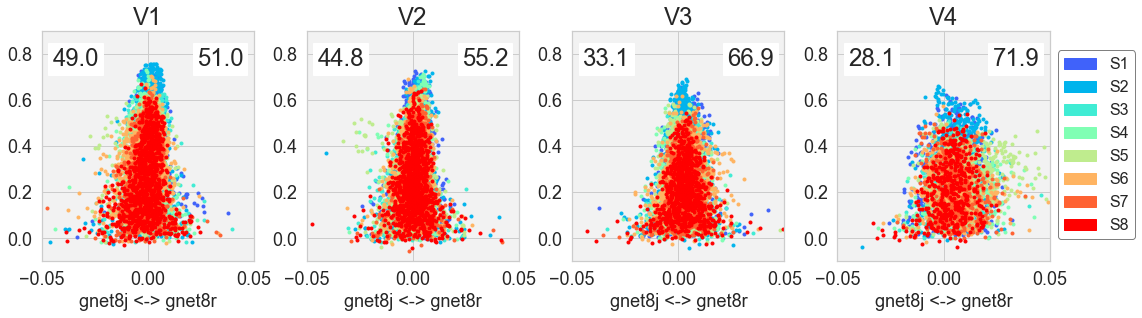

In [10]:
fig=plt.figure(figsize=(20,4))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.85, top=.9, wspace=0.25, hspace=0.25)
XY_roi_compare = {roi: [] for roi in roi_group_names}
axes = [plt.subplot(1,4,i+1) for i in range(len(roi_group_names))]

for k,s in enumerate(subjects):
    
    Y = joined_val_ccs[s]
    X = roiwise_val_ccs[s]

    for i, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, voxel_roi[s], roi_map, roi_group_names)):                
        plt.sca(axes[i])
        mask = roi_mask
        plt.plot( (X - Y)[mask], ((X+Y)/2)[mask], linestyle='None', marker='.', color=subj_cmap[s])
    
        XY_roi_compare[roi_name] += [(X - Y)[mask],]

        plt.xlim([-.05,.05])
        plt.ylim([-.1,.9])
        plt.title(roi_name)
    
for i,roi_name in enumerate(roi_group_names):
    plt.sca(axes[i])
    X = np.concatenate(XY_roi_compare[roi_name])
    plt.text(-.045, .75, '%.01f'%(np.sum(X<0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
    plt.text(.023, .75, '%.01f'%(np.sum(X>0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
    plt.xlabel('gnet8j <-> gnet8r')
                
plt.sca(axes[-1])          
legend_elements = [Patch(facecolor=subj_cmap[s], edgecolor=subj_cmap[s], label='S%d'%s) for s in subjects]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1., 0.95), fontsize=16, framealpha=1., facecolor='white', edgecolor='gray')

In [11]:
filename = output_dir + 'gnet8r_v_gnet8j_validation_accuracies%s'  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Load cross-ROI models

In [12]:
crossroi_val_ccs = {}
for roi_name in ['V1', 'V2', 'V3', 'hV4']:
    checkpoint = torch.load('%s%s/model_params'%(roiwise_dir, roi_name) )
    crossroi_val_ccs[roi_name] = checkpoint['val_cc']

# Subjectwise cross-model matrix

In [13]:
subj_val_mat = {s: np.zeros(shape=(len(roi_group_names), len(roi_group_names))) for s in voxel_roi.keys()}
all_mat = np.zeros(shape=(len(roi_group_names), len(roi_group_names)))
all_count = np.zeros(shape=(len(roi_group_names), len(roi_group_names)))
for i,(i_roi_name, val_cc) in enumerate(crossroi_val_ccs.items()):
    print ('%d - %s'%(i, i_roi_name))
    for s, v in val_cc.items():
        for j, (roi_mask, j_roi_name) in enumerate(iterate_roi(roi_group, voxel_roi[s], roi_map)):
            #print ('  %d - %s'%(j, j_roi_name))
            subj_val_mat[s][i,j] = np.mean(v[roi_mask] -  roiwise_val_ccs[s][roi_mask])
            all_mat[i,j] += np.sum(v[roi_mask] -  roiwise_val_ccs[s][roi_mask])
            all_count[i,j] += np.sum(roi_mask)

0 - V1
1 - V2
2 - V3
3 - hV4


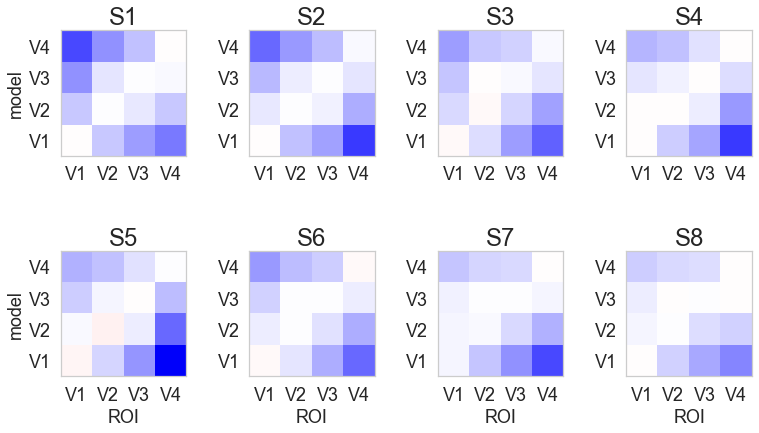

In [14]:
# line = model
# column = roi

fig=plt.figure(figsize=(12,6))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.95, top=.95, wspace=.5, hspace=.5)

for k,(s,mat) in enumerate(subj_val_mat.items()):
    plt.subplot(2,4,k+1)
    plt.imshow(mat, cmap='seismic', vmin=-.05, vmax=.05, origin='lower')
    plt.grid(False)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(roi_group_names)))
    ax.set_xticklabels(roi_group_names)
    ax.set_yticks(np.arange(len(roi_group_names)))
    ax.set_yticklabels(roi_group_names)
    if k%4==0:
        plt.ylabel('model')
    if k>=4:
        plt.xlabel('ROI')
    plt.title('S%s'%s)
    #if (k+1)%4==0:
    #    plt.colorbar()

In [15]:
filename = output_dir + 'gnet8r_xmodel_table%s'  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

Text(0.5, 0, 'ROI')

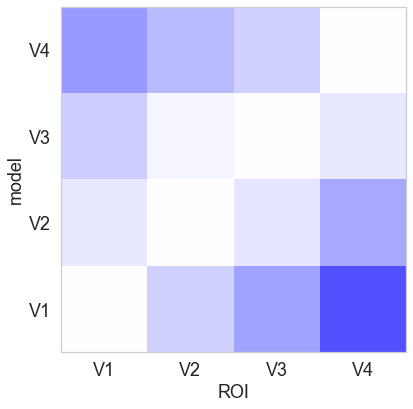

In [16]:
fig=plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.95, top=.95, wspace=.5, hspace=.5)

plt.imshow(all_mat/all_count, cmap='seismic', vmin=-.05, vmax=.05, origin='lower')
plt.grid(False)
ax = plt.gca()
ax.set_xticks(np.arange(len(roi_group_names)))
ax.set_xticklabels(roi_group_names)
ax.set_yticks(np.arange(len(roi_group_names)))
ax.set_yticklabels(roi_group_names)
plt.ylabel('model')
plt.xlabel('ROI')

In [17]:
filename = output_dir + 'gnet8r_xmodel_table_all%s'  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Characterization

In [18]:
D_mat = np.array([[0,1,2,3], [1,0,1,2], [2,1,0,1],  [3,2,1,0]])
D_up_tri_mat = np.array([[0,0,0,0], [1,0,0,0], [2,1,0,0], [3,2,1,0]])
D_dn_tri_mat = np.array([[0,1,2,3], [0,0,1,2], [0,0,0,1], [0,0,0,0]])

from scipy.optimize import curve_fit
def fit_fn(x, a):
    return a*x

alpha, dalpha = {}, {}
for s,m in subj_val_mat.items():

    popt, pcov = curve_fit(fit_fn, D_up_tri_mat.flatten()[D_up_tri_mat.flatten()>0], m.flatten()[D_up_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_up, da_up = popt[0], perr[0]

    popt, pcov = curve_fit(fit_fn, D_dn_tri_mat.flatten()[D_dn_tri_mat.flatten()>0], m.flatten()[D_dn_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_dn, da_dn = popt[0], perr[0]
    
    alpha[s]  = (a_up - a_dn) / ( np.abs(a_up) + np.abs(a_dn) )
    dalpha[s] = np.abs(alpha[s]) * np.sqrt( (da_up**2 + da_dn**2) / (a_up - a_dn)**2 + (da_up**2 + da_dn**2) / (np.abs(a_up) + np.abs(a_dn))**2  )
    print (s, ':', alpha[s], '+/-', dalpha[s])

1 : -0.17734744503428335 +/- 0.06886971594853625
2 : 0.07804203439059244 +/- 0.08674806192924936
3 : 0.23519290248826374 +/- 0.06641253811571647
4 : 0.426700961340345 +/- 0.09723173585414262
5 : 0.48017068399775836 +/- 0.1051010389203816
6 : 0.1809194430032612 +/- 0.07782630678634257
7 : 0.5111321538903085 +/- 0.11207546786963368
8 : 0.3950551386170815 +/- 0.126828696789439


In [19]:
for s,m in {'all': all_mat/all_count}.items():

    popt, pcov = curve_fit(fit_fn, D_up_tri_mat.flatten()[D_up_tri_mat.flatten()>0], m.flatten()[D_up_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_up, da_up = popt[0], perr[0]

    popt, pcov = curve_fit(fit_fn, D_dn_tri_mat.flatten()[D_dn_tri_mat.flatten()>0], m.flatten()[D_dn_tri_mat.flatten()>0])
    perr = np.sqrt(np.diag(pcov))
    a_dn, da_dn = popt[0], perr[0]
    
    alpha[s]  = (a_up - a_dn) / ( np.abs(a_up) + np.abs(a_dn) )
    dalpha[s] = np.abs(alpha[s]) * np.sqrt( (da_up**2 + da_dn**2) / (a_up - a_dn)**2 + (da_up**2 + da_dn**2) / (np.abs(a_up) + np.abs(a_dn))**2  )
    print (s, ':', alpha[s], '+/-', dalpha[s])

all : 0.22605113899727913 +/- 0.07231789415950508
